--- Describing Data ---
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Price               2059 non-null   int64  
 1   Year                2059 non-null   int64  
 2   Kilometer           2059 non-null   int64  
 3   Fuel Type           2059 non-null   object 
 4   Transmission        2059 non-null   object 
 5   Engine              1979 non-null   object 
 6   Max Power           1979 non-null   object 
 7   Max Torque          1979 non-null   object 
 8   Length              1995 non-null   float64
 9   Width               1995 non-null   float64
 10  Fuel Tank Capacity  1946 non-null   float64
dtypes: float64(3), int64(3), object(5)
memory usage: 177.1+ KB
None

Descriptive Statistics:
               Price         Year     Kilometer Fuel Type Transmission  \
count   2.059000e+03  2059.000000  2.059000e+03   

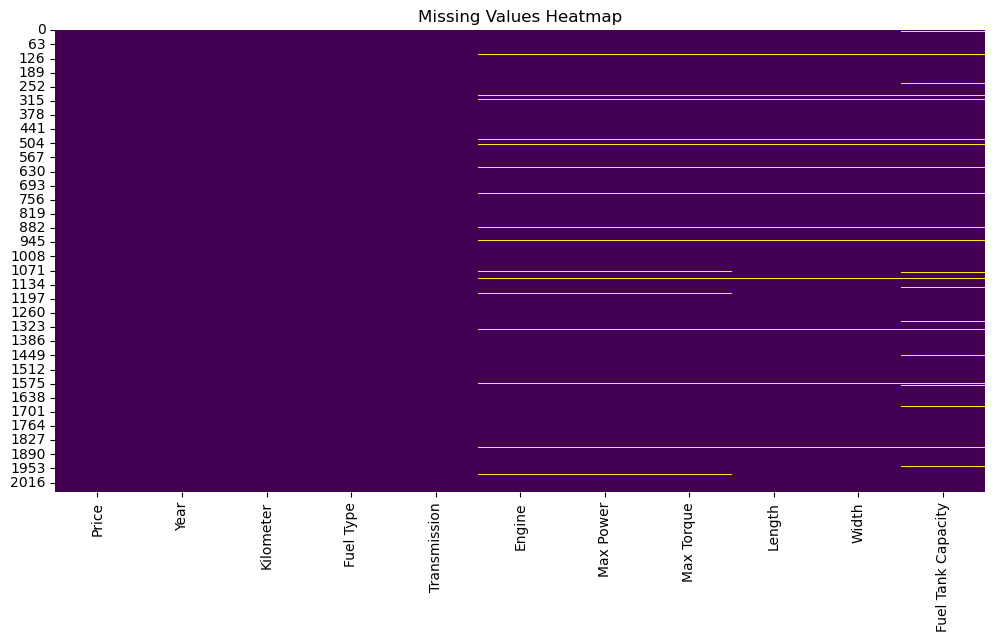

--- Plotting Target Variable Distribution ---


c:\Users\yings\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


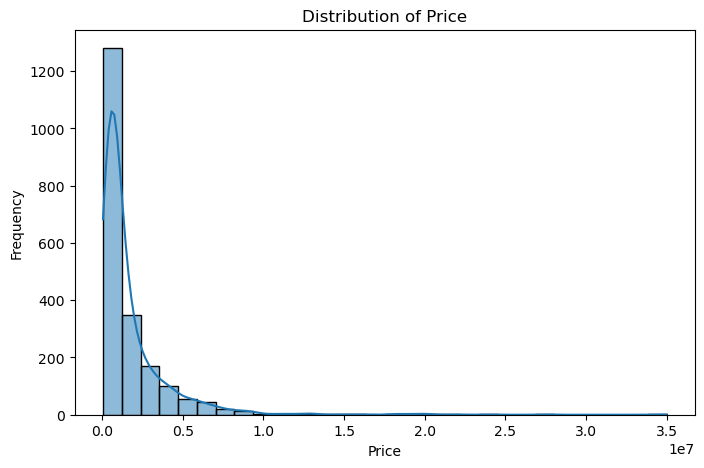

--- Detecting Outliers ---


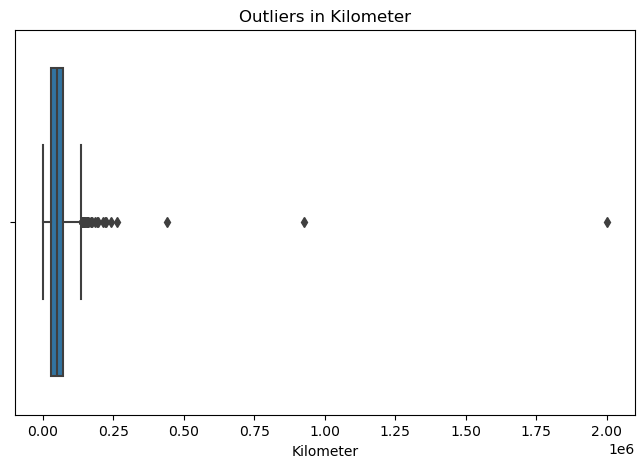

--- Correlation Analysis ---

Correlations with Price:
Price                 1.000000
Fuel Tank Capacity    0.584631
Width                 0.563996
Length                0.556741
Year                  0.311400
Kilometer            -0.150825
Name: Price, dtype: float64


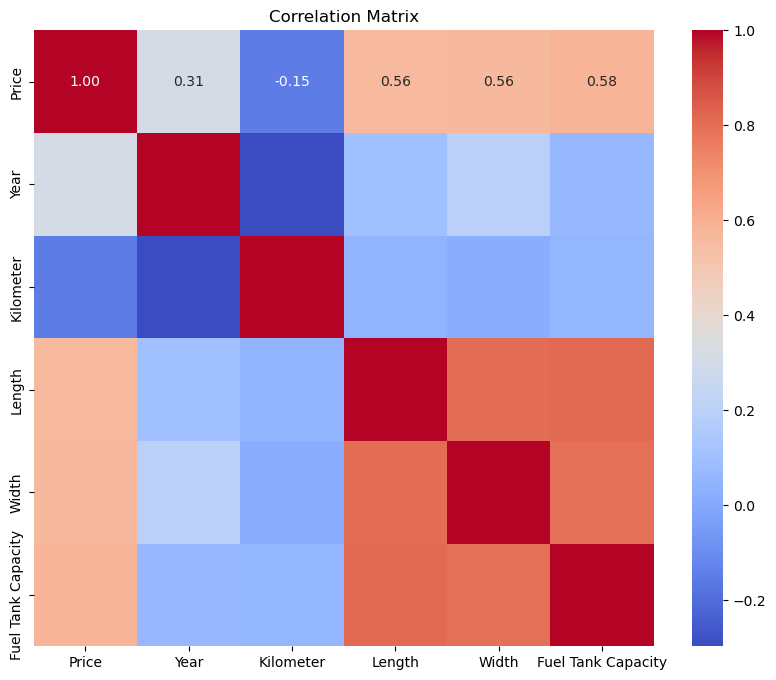

In [16]:
import sys
from pathlib import Path

# Dynamically add the project root to Python path
project_root = Path().resolve().parent # Adjust based on structure
sys.path.append(str(project_root))

import pandas as pd
from data.load_data import load_data
from src.EDA import (
    describe_data,
    check_missing_values,
    plot_target_distribution,
    detect_outliers,
    correlation_analysis,
)

# Define file path dynamically
file_path = project_root / "data" / "raw_data.csv"

# Load and clean the dataset
try:
    data = load_data(file_path)
except FileNotFoundError:
    print(f"File not found: {file_path}")
    sys.exit(1)
except Exception as e:
    print(f"An error occurred while loading data: {e}")
    sys.exit(1)

# Perform EDA
print("--- Describing Data ---")
description = describe_data(data)
print(description)

print("--- Checking Missing Values ---")
missing_values = check_missing_values(data)

print("--- Plotting Target Variable Distribution ---")
target_col = "Price"  # Define the target column
plot_target_distribution(data, target_col)

print("--- Detecting Outliers ---")
outlier_col = "Kilometer"  # Define a column to check for outliers
detect_outliers(data, outlier_col)

print("--- Correlation Analysis ---")
correlations = correlation_analysis(data, target_col)


In [17]:
import pandas as pd
import re  # For regular expression operations
import numpy as np

# Load the dataset
data_path = "../data/raw_data.csv"  # Adjust the path as needed
df = pd.read_csv(data_path)

# Display the dataset preview
print("Dataset Preview:")
display(df.head())

# Define a function to extract the first numerical value from a string
def extract_first_number(text):
    match = re.search(r'\d+(\.\d+)?', str(text))  # Matches integers or decimals
    return float(match.group()) if match else None

# Define a function to extract the second numerical value from a string
def extract_second_number(text):
    matches = re.findall(r'\d+', str(text))
    return int(matches[1]) if len(matches) > 1 else None

# Apply the functions to split 'Max Power' column
df['Max Power Value'] = df['Max Power'].apply(extract_first_number)
df['Max Power RPM'] = df['Max Power'].apply(extract_second_number)

# Apply the functions to split 'Max Torque' column
df['Max Torque Value'] = df['Max Torque'].apply(extract_first_number)
df['Max Torque RPM'] = df['Max Torque'].apply(extract_second_number)

# Drop the original 'Max Power' and 'Max Torque' columns
df = df.drop(columns=['Max Power', 'Max Torque'])

# Define a function to extract the first numerical value from the Engine column
def clean_engine(text):
    match = re.search(r'\d+', str(text))  # Matches integers
    return int(match.group()) if match else None

# Apply the function to the 'Engine' column
df['Engine'] = df['Engine'].apply(clean_engine)

initial_nulls = df.isnull().sum().sum()
initial_duplicates = df.duplicated().sum()
initial_rows = df.shape[0]

# Handle missing/null values
def handle_missing_values(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    return df

df = handle_missing_values(df)

# Remove duplicates
df = df.drop_duplicates()

# Remove outliers before log transformation
def remove_outliers(df, columns):
    for col in columns:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

outlier_columns = ['Price', 'Kilometer', 'Engine', 'Max Power Value', 'Max Power RPM', 'Max Torque RPM', 'Max Torque Value', 'Length', 'Width', 'Fuel Tank Capacity']
df = remove_outliers(df, outlier_columns)

# After cleaning statistics
final_nulls = df.isnull().sum().sum()
final_duplicates = df.duplicated().sum()
final_rows = df.shape[0]

# List of skewed numerical features (exclude 'Year' as it is not suitable for log transformation)
skewed_features = ['Price', 'Year', 'Max Power RPM', 'Max Torque RPM', 'Kilometer', 'Engine', 'Max Power Value', 'Max Torque Value']

# Check for zeros before applying log transformation
for col in skewed_features:
    if (df[col] <= 0).any():
        print(f"Warning: Column '{col}' contains non-positive values. Adding a small constant for log transformation.")
        df[col] += 1e-5

# Apply log transformation to skewed features
for col in skewed_features:
    df[col] = np.log1p(df[col])  # log1p(x) = log(x + 1)

# Display the updated dataset preview
print("\n--- Updated Dataset ---")
display(df.head())

# Display comparison
print("\n--- Data Cleaning Comparison ---")
print(f"Total Rows Before Cleaning: {initial_rows}")
print(f"Total Rows After Cleaning: {final_rows}")
print(f"Total Null Values Before Cleaning: {initial_nulls}")
print(f"Total Null Values After Cleaning: {final_nulls}")
print(f"Total Duplicates Before Cleaning: {initial_duplicates}")
print(f"Total Duplicates After Cleaning: {final_duplicates}")

# Save the updated dataset in Parquet format
output_path = "../data/processed_data.parquet"  # Adjust path if necessary
df.to_parquet(output_path, index=False)
print(f"\nUpdated dataset saved to {output_path}")


Dataset Preview:


,Price,Year,Kilometer,Fuel Type,Transmission,Engine,Max Power,Max Torque,Length,Width,Fuel Tank Capacity
0,505000,2017,87150,Petrol,Manual,1198 cc,87 bhp @ 6000 rpm,109 Nm @ 4500 rpm,3990.0,1680.0,35.0
1,450000,2014,75000,Diesel,Manual,1248 cc,74 bhp @ 4000 rpm,190 Nm @ 2000 rpm,3995.0,1695.0,42.0
2,220000,2011,67000,Petrol,Manual,1197 cc,79 bhp @ 6000 rpm,112.7619 Nm @ 4000 rpm,3585.0,1595.0,35.0
3,799000,2019,37500,Petrol,Manual,1197 cc,82 bhp @ 6000 rpm,113 Nm @ 4200 rpm,3995.0,1745.0,37.0
4,1950000,2018,69000,Diesel,Manual,2393 cc,148 bhp @ 3400 rpm,343 Nm @ 1400 rpm,4735.0,1830.0,55.0



--- Updated Dataset ---


,Price,Year,Kilometer,Fuel Type,Transmission,Engine,Length,Width,Fuel Tank Capacity,Max Power Value,Max Power RPM,Max Torque Value,Max Torque RPM
0,13.132316,7.609862,11.375398,Petrol,Manual,7.089243,3990.0,1680.0,35.0,4.477337,8.699681,4.700480,8.412055
1,13.017005,7.608374,11.225257,Diesel,Manual,7.130099,3995.0,1695.0,42.0,4.317488,8.294300,5.252273,7.601402
3,13.591117,7.610853,10.532123,Petrol,Manual,7.088409,3995.0,1745.0,37.0,4.418841,8.699681,4.736198,8.343078
4,14.483340,7.610358,11.141876,Diesel,Manual,7.780721,4735.0,1830.0,55.0,5.003946,8.131825,5.840642,7.244942
5,13.422469,7.609862,11.202534,Petrol,Manual,7.225481,4490.0,1730.0,43.0,4.521789,8.699681,4.875197,8.294300



--- Data Cleaning Comparison ---
Total Rows Before Cleaning: 2059
Total Rows After Cleaning: 1521
Total Null Values Before Cleaning: 645
Total Null Values After Cleaning: 0
Total Duplicates Before Cleaning: 8
Total Duplicates After Cleaning: 0

Updated dataset saved to ../data/processed_data.parquet
